In [17]:
import os
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

In [18]:
#######################################################################################################
#Load saved model
#######################################################################################################
os.chdir(r'I:\DM PROJECT\modelsave')
ts_model=load_model(os.path.join(os.getcwd(), "lstm_model.h5"))
ts_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 1, 64)             200960    
                                                                 
 lstm_76 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_77 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_78 (LSTM)              (None, 64)                33024     
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 300,097
Trainable params: 300,097
Non-trainable params: 0
_________________________________________________________________


In [19]:
#######################################################################################################
np.random.seed(1)
#Load the sequence data from csv
df = pd.read_csv('I:\DM PROJECT\originaldataset\AEP_hourly.csv')
requests = pd.DataFrame(data=df,columns=['AEP_MW'])
#if any missing value fill it by previous value and convert all requests into integer type
requests.ffill(inplace=True)
requests["AEP_MW"]=requests["AEP_MW"].astype(float).astype(int)
##############################################################################################################
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)

In [20]:
#############################################################################
#scale the data
print("Request Range before scaling:",min(requests.AEP_MW),max(requests.AEP_MW))
scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests)
print("Request Range after scaling:",min(scaled_requests),max(scaled_requests))

#Traing data has to be sequential
train_size = int(len(df)*0.80)
test_size =len(df)-train_size

#Number of samples to lookback for each sample
#720 default
lookback =720

#sperate training and test data
train_data = scaled_requests[0:train_size,:]

#Add an additional week for lookback
test_data = scaled_requests[train_size:len(df),:1]

print("\n Shaped of Train ,Test :", train_data.shape ,test_data.shape)


Request Range before scaling: 9581 25695
Request Range after scaling: [-2.28391613] [3.93437215]

 Shaped of Train ,Test : (97018, 1) (24255, 1)


In [21]:
#####################################################################################################
#pepare RNN Dataset
def create_rnn_dataset(data, lookback=1):
  
  data_x,data_y = [],[]
  for i in range(len(data)- lookback -1):
    a = data[i:(i + lookback),0]
    data_x.append(a)
    data_y.append(data[i + lookback,0])
  return np.array(data_x),np.array(data_y)

#create x and y for training
x_train , y_train = create_rnn_dataset(train_data , lookback)

#Reshape for use with LSTM
x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))

print("shapes of x,y:",x_train.shape , y_train.shape)
##############################################################################
#Preprocess
x_test , y_test =create_rnn_dataset(test_data , lookback)
x_test = np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))
ts_model.evaluate(x_test , y_test, verbose=1)

#predict for the training dataset
predict_on_train = ts_model.predict(x_train)
#Prdeict on the test dataset
predict_on_test = ts_model.predict(x_test)

#train_mae_loss = np.mean(np.abs(predict_on_train - x_train), axis=1)

shapes of x,y: (96297, 1, 720) (96297,)
736/736 [==============================] - 2s 3ms/step


In [22]:



##########################################################################

from sklearn.metrics import r2_score
score = r2_score(y_test, predict_on_test)
print("The accuracy of our model is {}%".format(round(score, 2) *100))
######################################################################
from sklearn import metrics
import os
score = np.sqrt(metrics.mean_squared_error(y_test,predict_on_test))
print(f'After training the RMSE is:{score}')
#######################################################################
# trainMAE = np.mean(np.abs(predict_on_train - x_train), axis=1)
# testMAE = np.mean(np.abs(predict_on_test - x_test), axis=1)
# print(f'After training the MAE is:{testMAE}')
# #########################################################################
# plt.hist(testMAE , bins=50)
# plt.xlabel('Test MAE loss')
# plt.ylabel('Number of samples')
################################################################################

################################################################################
predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)
##############################################################################

The accuracy of our model is 98.0%
After training the RMSE is:0.13021351563606942


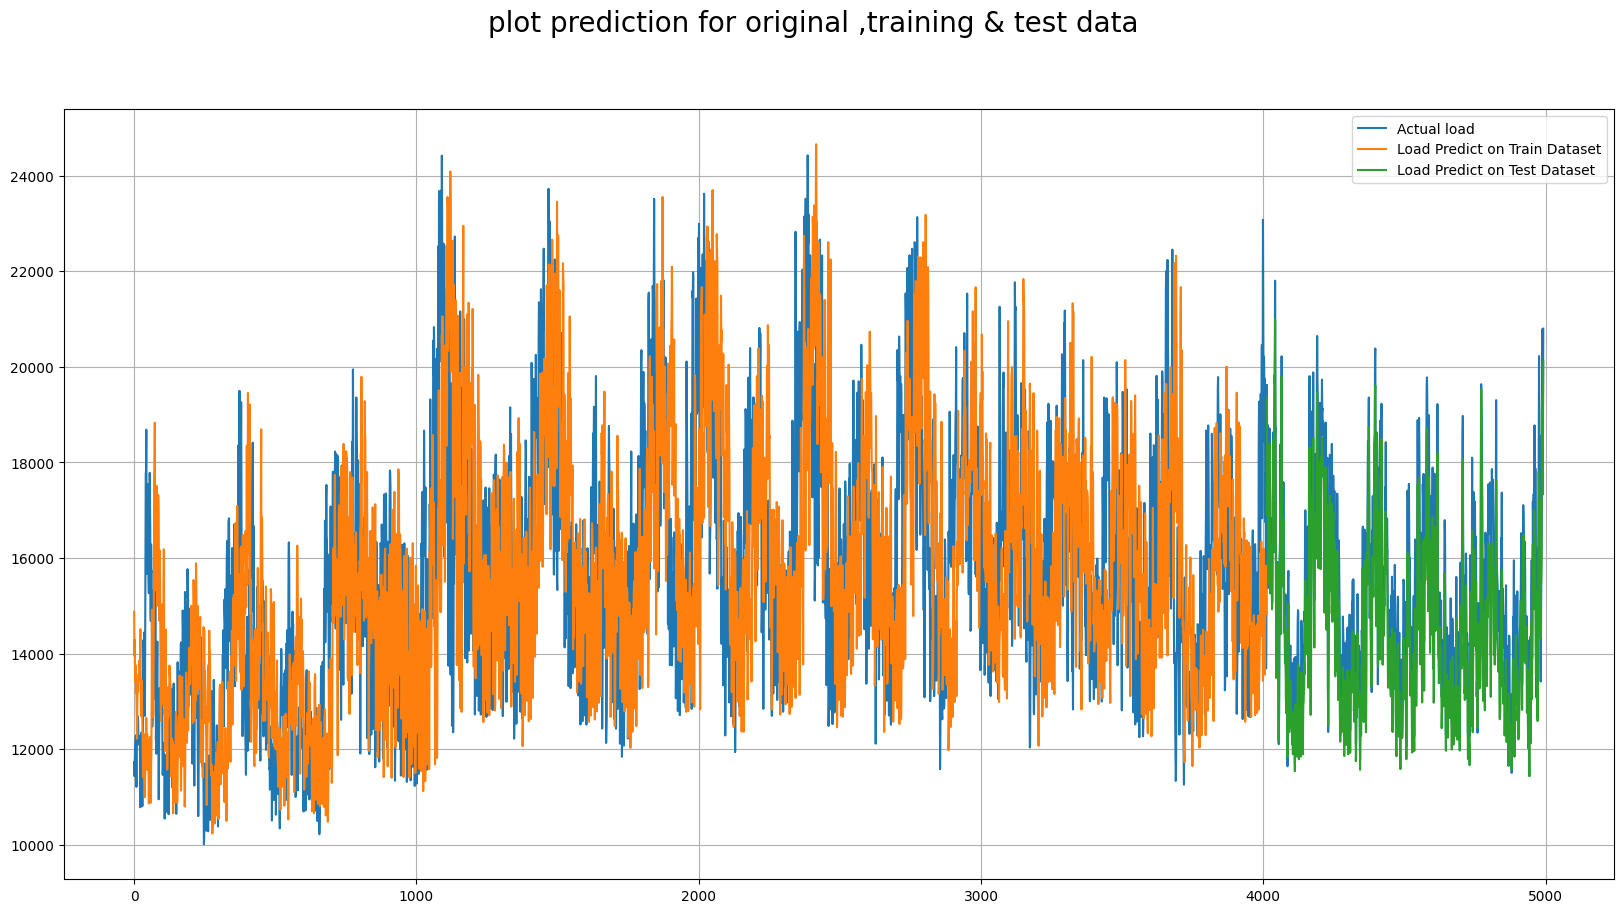

In [23]:
#Plot the predictions

#Total size of plot
total_size = len(predict_on_train)+ len(predict_on_test)

#plot original data 
orig_data =requests.AEP_MW.to_numpy()
orig_data = orig_data.reshape(len(orig_data),1)

#cretae a plot for original data
orig_plot = np.empty((total_size , 1))
orig_plot[:,:] = np.nan
orig_plot[0:total_size,:]= orig_data[lookback*2:-2,]

#Create a plot for prediction on training
predict_train_plot =np.empty((total_size , 1))
predict_train_plot[:,:] = np.nan
predict_train_plot[0:len(predict_on_train),:] = predict_on_train

#Create a plot for prediction on testing
predict_test_plot =np.empty((total_size , 1))
predict_test_plot[:,:] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test),:]=predict_on_test

#plot the graphs
plt.figure(figsize=(20,10)).suptitle("plot prediction for original ,training & test data", fontsize=20)
plt.plot(orig_plot[::24], label='Actual load')
plt.plot(predict_train_plot[::24], label='Load Predict on Train Dataset')
plt.plot(predict_test_plot[::24], label='Load Predict on Test Dataset')
# Function add a legend
plt.legend()
plt.grid()
plt.show()

df1 = pd.DataFrame(orig_plot[::24], columns = ['original_AEP_MW'])
# Convert DataFrame to JSON
data = df1.to_json('I:\DM PROJECT\outputs\original_AEP_MW_export.json', orient='records')

df2 = pd.DataFrame(predict_train_plot[::24], columns = ['predict_train_MW'])
# Convert DataFrame to JSON
data = df2.to_json('I:\DM PROJECT\outputs\predict_train_AEP_MW_export.json', orient='records')

df3 = pd.DataFrame(predict_test_plot[::24], columns = ['predict_test_AEP_MW'])
# Convert DataFrame to JSON
data = df3.to_json('I:\DM PROJECT\outputs\predict_test_AEP_MW_export.json', orient='records')
#print(df1.head(6))

Forecasting future Electricity loads

In [24]:
###############################################################################
#Forecasting future Service loads
###############################################################################
curr_input = x_test[-1,:].flatten()
#Predict for the hours
#loopback is used 
predict_for =24*30
for i in range(predict_for):
  this_input = curr_input[-lookback:]
  this_input = this_input.reshape((1,1,lookback))
  this_prediction = ts_model.predict(this_input)

  curr_input = np.append(curr_input, this_prediction.flatten())
predict_on_future = np.reshape(np.array(curr_input[predict_for:]),(predict_for,1))
predict_on_future=scaler.inverse_transform(predict_on_future)

print(predict_on_future[:5])
####################################################################
#type(predict_on_future[:5])
df4 = pd.DataFrame(predict_on_future[:5], columns = ['predict_on_future_MW'])
# Convert DataFrame to JSON
data = df4.to_json('I:\DM PROJECT\outputs\predict_on_future_AEP_MW_export.json', orient='records')

1/1 [==============================] - 0s 24ms/step
[[20658.84425388]
 [20297.57164552]
 [19173.14444371]
 [19622.43106525]
 [19542.9740687 ]]


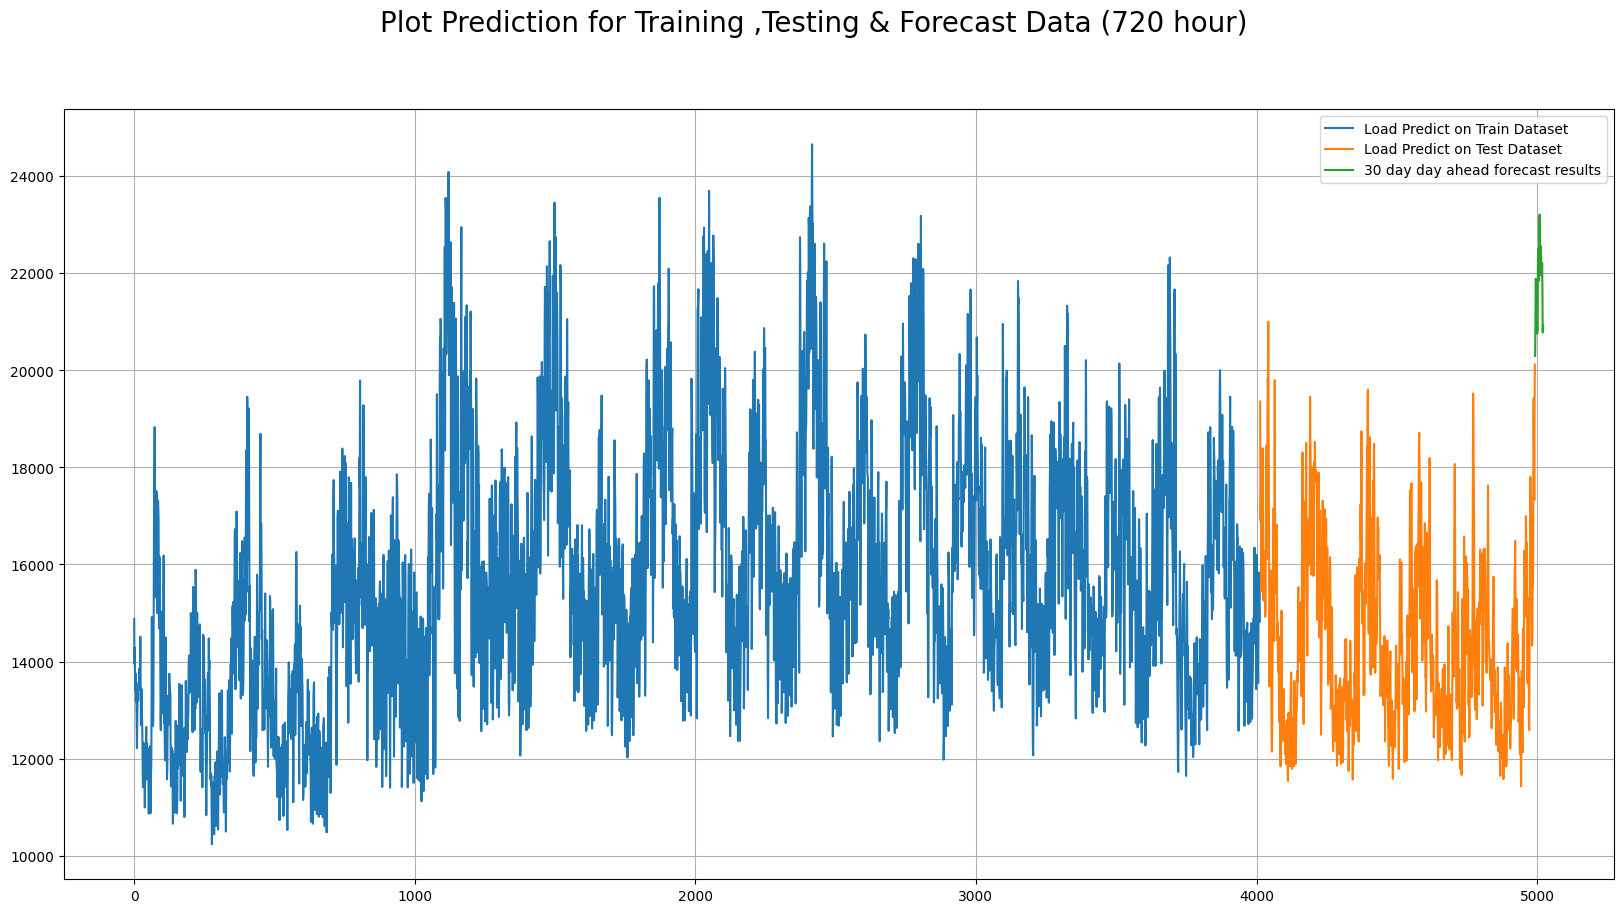

In [25]:
#####################################################################
#plot the traunung data with the forcasting data
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)
                                                                
#setup training chart
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:,:] = np.nan
predict_train_plot[0:len(predict_on_train),:] = predict_on_train 

#setup test chart
predict_test_plot = np.empty((total_size , 1))
predict_test_plot[:,:] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test),:]=predict_on_test

#setup future forecast chart
predict_future_plot = np.empty((total_size,1))
predict_future_plot[:,:]=np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size,:]=predict_on_future

plt.figure(figsize=(20,10)).suptitle("Plot Prediction for Training ,Testing & Forecast Data (720 hour)",fontsize=20)
plt.plot(predict_train_plot[::24], label='Load Predict on Train Dataset')
plt.plot(predict_test_plot[::24], label='Load Predict on Test Dataset')
plt.plot(predict_future_plot[::24], label='30 day day ahead forecast results')
plt.legend()
plt.grid()
plt.show()

##############################################################################################################
# plt.figure(figsize=(20,5)).suptitle("predicted Data Request -Next 720 hours",fontsize=20)
# plt.plot(predict_on_future , color='g')
# plt.show()

In [26]:
###################################################################################################################
from datetime import datetime , timedelta
def daterange(start_date,end_date):
  delta = timedelta(hours=1)
  while start_date< end_date:
    yield start_date
    start_date += delta

predicted_dates=[]

#input dataset end date upto which dataset is trained and tested and end date is upmost date upto which data is to be predicted -1 year
start_date = datetime(2013,12,31,00,00)
end_date =datetime(2014,12,30,23,59)
for single_date in daterange(start_date, end_date):
  d=single_date.strftime("%Y-%m-%d %H:%M")
  predicted_dates.append(d)
#print(predicted_dates)


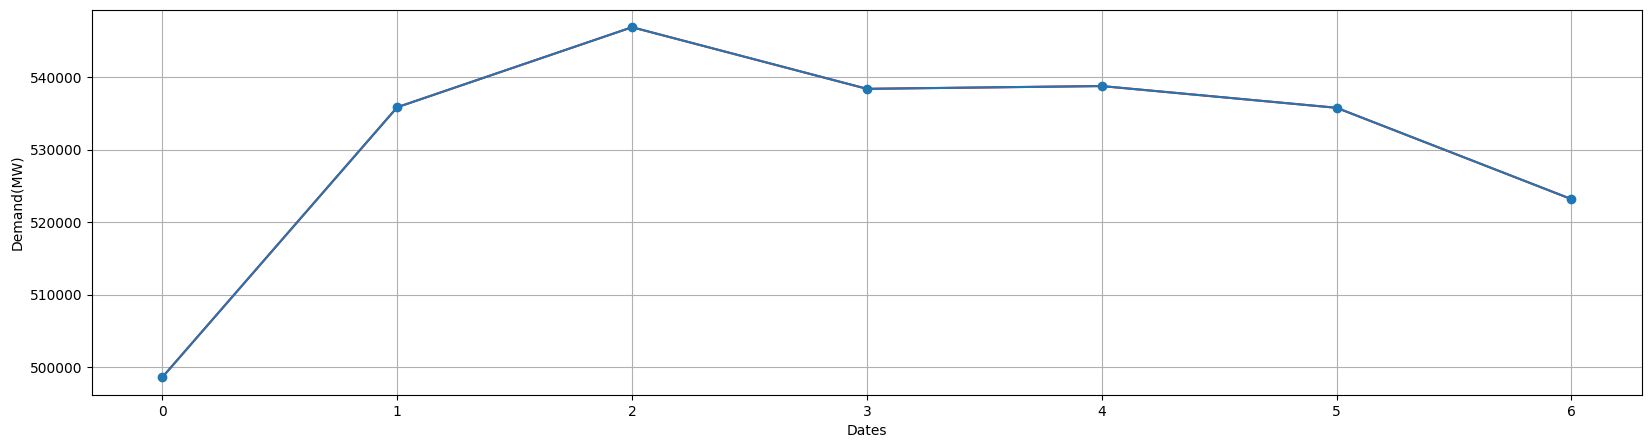

In [27]:
###################################################################################
#plotting Weekly data
y_values = predict_on_future[:175]
y_list = [item for sublist in y_values for item in sublist]


total_day_requests=[]
c=0
req_sum=0
for i in range(len(y_list)):
  if c==24:
    c=0
    total_day_requests.append(req_sum)
    req_sum=0
  else:
    req_sum+=y_list[i]
    c+=1

#print(total_day_requets)
fig ,ax =plt.subplots(figsize=(20,5))

#Add x=axis and y-axis

ax.plot(total_day_requests , color='red')
plt.plot(total_day_requests, marker = 'o')
plt.xlabel("Dates")
plt.ylabel("Demand(MW)")
plt.grid()
plt.show()
#set title and lable for axes
ax.set(#xlable="Date",
       #ylable="AEP_MW",
       title="Predicted Next week Energy Demand\n")
week_dates=[]
for i in range(len(predicted_dates)):
  if i%24==0:
    week_dates.append(predicted_dates[i])
week_points=[x for x in range(7)]

seven_day_Df = pd.DataFrame(data={
    "Date":week_points,
    "PredictedMegaWatt": total_day_requests
})
# Convert DataFrame to JSON
data = seven_day_Df.to_json('I:\DM PROJECT\outputs\seven_day_predict_data_export.json', orient='records')
#print(total_day_requests)
#print(week_dates)
#plt.show()

